<a href="https://colab.research.google.com/github/SuperSus/samples/blob/master/scut_pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*italicized text*
!pip3 install torch==1.4.0+cu92 torchvision==0.5.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html

In [154]:
# !pip3 install torch==1.4.0+cu92 torchvision==0.5.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.models as models
from torch.optim import lr_scheduler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
from IPython.display import display
import os.path
import dlib             # face detection
from torch.utils.data import Dataset
import copy

# Filter harmless warnings
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

ModuleNotFoundError: ignored

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
!unzip '/content/drive/My Drive/Colab Notebooks/datasets/SCUT-FBP5500_v2.1.zip';

Streaming output truncated to the last 5000 lines.
  inflating: SCUT-FBP5500_v2/Images/AF401.jpg  
  inflating: SCUT-FBP5500_v2/Images/AF503.jpg  
  inflating: SCUT-FBP5500_v2/Images/AF515.jpg  
  inflating: SCUT-FBP5500_v2/Images/AF529.jpg  
  inflating: SCUT-FBP5500_v2/Images/AF55.jpg  
  inflating: SCUT-FBP5500_v2/Images/AF620.jpg  
  inflating: SCUT-FBP5500_v2/Images/AF633.jpg  
  inflating: SCUT-FBP5500_v2/Images/AF635.jpg  
  inflating: SCUT-FBP5500_v2/Images/AF64.jpg  
  inflating: SCUT-FBP5500_v2/Images/AF67.jpg  
  inflating: SCUT-FBP5500_v2/Images/AF699.jpg  
  inflating: SCUT-FBP5500_v2/Images/AF746.jpg  
  inflating: SCUT-FBP5500_v2/Images/AF747.jpg  
  inflating: SCUT-FBP5500_v2/Images/AF764.jpg  
  inflating: SCUT-FBP5500_v2/Images/AF768.jpg  
  inflating: SCUT-FBP5500_v2/Images/AF781.jpg  
  inflating: SCUT-FBP5500_v2/Images/AF796.jpg  
  inflating: SCUT-FBP5500_v2/Images/AF81.jpg  
  inflating: SCUT-FBP5500_v2/Images/AF148.jpg  
  inflating: SCUT-FBP5500_v2/Images/AF148

In [0]:
# resnet = torchvision.models.resnet50(pretrained=False, progress=True)

In [0]:
# with Image.open('/content/SCUT-FBP5500_v2/Images/AF1.jpg') as im:
#     display(im)

# path = '/content/SCUT-FBP5500_v2/Images/'
# img_names = []

# for folder, subfolders, filenames in os.walk(path):
#     for img in filenames:
#         img_names.append(folder + '/'+img)
        
# print('Images: ',len(img_names))

# # Start by creating a list
# img_sizes = []
# rejected = []

# for item in img_names:
#     try:
#         with Image.open(item) as img:
#             img_sizes.append(img.size)
#     except:
#         rejected.append(item)
        
# print(f'Images:  {len(img_sizes)}')
# print(f'Rejects: {len(rejected)}')

# # Convert the list to a DataFrame
# df = pd.DataFrame(img_sizes)

# # Run summary statistics on image widths
# df[0].describe()

# transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(p=1),  # normally we'd set p=0.5
#     transforms.RandomRotation(30),
#     transforms.Resize(224),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406],
#                          [0.229, 0.224, 0.225]),
# ])
# im = transform(Image.open(f'{path}/AF1.jpg'))
# print(im.shape)
# plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

Images:  5500


In [0]:
import torchvision.transforms as transforms
import numpy as np
import dlib

class PILTransforms:

    @staticmethod
    def crop_face():

        def crop(image): 
            image_ary = np.array(image)

            # detect and crop face
            detector = dlib.get_frontal_face_detector()
            det = detector(image_ary)

            if len(det) > 0:
                d = det[0]

                box = (d.left(), d.top(), d.right(), d.bottom())

                image = image.crop(box)
            
            return image 

        return transforms.Lambda(crop)

In [0]:
class CSVDataset(Dataset):
    """CSV dataset."""

    def __init__(self, csv_file, image_dir, transform, type=float):
        """
        Args:
            csv_file (string): Path to the csv file with labels/scores.
            image_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.images = pd.read_csv(csv_file, sep=' ', decimal='.')
        self.image_dir = image_dir
        self.transform = transform
        self.type = type

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir,
                                self.images.iloc[idx, 0])

        score = self.type(self.images.iloc[idx, 1])

        # load image
        image = Image.open(img_name)
        #print("-->img")
        #print(img_name)
        # apply transform
        if self.transform:
            image = self.transform(image)

        return image, score

In [0]:
df_train = pd.read_csv('/content/SCUT-FBP5500_v2/train_test_files/split_of_60%training and 40%testing/train.txt', sep=' ', decimal='.', header = None)
df_test = pd.read_csv('/content/SCUT-FBP5500_v2/train_test_files/split_of_60%training and 40%testing/test.txt', sep=' ', decimal='.', header = None)

df1 = df_test.sample(frac =.7)
df_test = df_test.drop(df1.index)
df_train = pd.concat([df_train, df1]).reset_index(drop=True)
df_train.to_csv('train_90',sep=' ', decimal='.', index=False)
df_test.to_csv('test_10',sep=' ', decimal='.', index=False)

In [189]:
base_path = '/content/SCUT-FBP5500_v2/' 

# train_data = CSVDataset(
#     image_dir=os.path.join(base_path, 'Images'),
#     csv_file=os.path.join(base_path, 'train_test_files/split_of_60%training and 40%testing/train.txt'),
#     transform=train_transform)

# test_data = CSVDataset(
#     image_dir=os.path.join(base_path, 'Images'),
#     csv_file=os.path.join(base_path, 'train_test_files/split_of_60%training and 40%testing/test.txt'),
#     transform=test_transform)

# transforms.RandomResizedCrop(size=224),
# PILTransforms.crop_face(),  
# transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
train_transform = transforms.Compose([                          
        transforms.RandomRotation(20),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(300),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.CenterCrop(300),
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

train_data = CSVDataset(
    image_dir=os.path.join(base_path, 'Images'),
    csv_file='train_90',
    transform=train_transform)

test_data = CSVDataset(
    image_dir=os.path.join(base_path, 'Images'),
    csv_file='test_10',
    transform=test_transform)

torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')

Training images available: 4840
Testing images available:  660


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


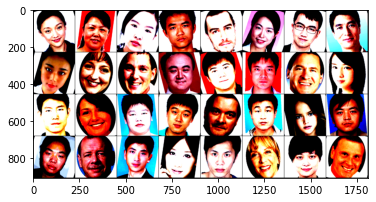

In [190]:
## functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)),)

## get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

## show images
imshow(torchvision.utils.make_grid(images))

In [0]:
# model_ft = torchvision.models.resnet50(pretrained=True, progress=True)
# for param in model_ft.parameters():
#     param.requires_grad = False

# num_ftrs = model_ft.fc.in_features
# print(num_ftrs)
# model_ft.fc = nn.Linear(num_ftrs, 1)

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model_ft.to(device)
# criterion = nn.MSELoss()
# learning_rate = 0.001
# optimizer = torch.optim.Adam(model_ft.fc.parameters(), lr=learning_rate)


2048


In [0]:
# num_epochs = 15

# for epoch in range(num_epochs):
#     train_running_loss = 0.0
#     train_acc = 0.0

#     model = model_ft.train()

#     ## training step
#     for i, (images, labels) in enumerate(train_loader):
#         images = images.to(device)
#         labels = labels.to(device)
  
#         ## forward + backprop + loss
        
#         logits = model(images)
#         loss = criterion(logits.double().flatten(), labels.double())
#         optimizer.zero_grad()
#         loss.backward()
#         ## update model params
#         optimizer.step()

#         train_running_loss += loss.detach().item()
#         # train_acc += get_accuracy(logits, labels, BATCH_SIZE)
    
#     model.eval()
#     print('Epoch: %d | Loss: %.4f' \
#           %(epoch, train_running_loss / i))

NameError: ignored

2.4666669999999997
tensor([[2.9746]], device='cuda:0')


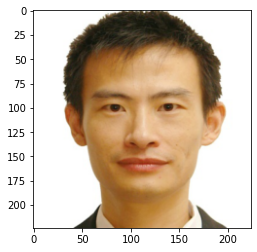

In [0]:
# x=1100
# inv_normalize = transforms.Normalize(
#     mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
#     std=[1/0.229, 1/0.224, 1/0.225]
# )
# im = inv_normalize(test_data[x][0])
# print(test_data[x][1])
# plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

# with torch.no_grad():
#     new_pred = model(test_data[x][0].view(1,3,224,224).to(device))
#     print(new_pred)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])
tensor([[2.8974]], device='cuda:0')


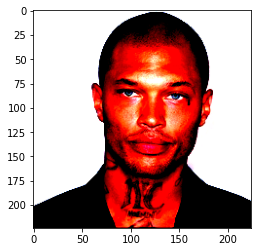

In [0]:
# im = inv_normalize(test_transform(Image.open('ret.jpg')))
# print(im.shape)
# plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

# with torch.no_grad():
#     new_pred = model(im.view(1,3,224,224).to(device))
#     print(new_pred)

# with torch.no_grad():
#     new_pred = model(test_data[x][0].view(1,3,224,224).to(device))
#     print(new_pred)

# Mobnet Beauty Pred

In [0]:
mobnet = models.mobilenet_v2(pretrained=True)
mobnet.classifier = nn.Sequential(nn.Dropout(p=0.2, inplace=False),
  nn.Linear(in_features=1280, out_features=1000, bias=True),
  nn.Linear(1000, 1))
# nn.Sequential(nn.Linear(9216, 1024),
#                                  nn.ReLU(),
#                                  nn.Dropout(0.4),
#                                  nn.Linear(1024, 2),
#                                  nn.LogSoftmax(dim=1))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
mobnet.to(device)
criterion = nn.MSELoss()
learning_rate = 0.003
optimizer = torch.optim.Adam(mobnet.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [193]:
num_epochs = 25
best_model_wts = copy.deepcopy(mobnet.state_dict())

for epoch in range(num_epochs):
    train_running_loss = 0.0
    valid_loss = 0.0
    best_loss = 1000

    model = mobnet.train()

    ## training step
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
  
        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits.double().flatten(), labels.double())
        # print(logits, labels.shape)
        optimizer.zero_grad()
        loss.backward()
        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
    train_running_loss /= i
    scheduler.step()

    model.eval()
    # validation
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        with torch.no_grad():
          logits = model(images)
          loss = criterion(logits.double().flatten(), labels.double())

        valid_loss += loss.detach().item()      
    valid_loss /= i

    if train_running_loss < best_loss:
      best_loss = train_running_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print('Epoch: %d | Loss: %.4f | Validation Loss: %.4f' \
          %(epoch, train_running_loss, valid_loss))

Epoch: 0 | Loss: 9.8384 | Validation Loss: 0.5741
Epoch: 1 | Loss: 0.3867 | Validation Loss: 0.3313
Epoch: 2 | Loss: 0.2613 | Validation Loss: 0.1788
Epoch: 3 | Loss: 0.2059 | Validation Loss: 0.2108
Epoch: 4 | Loss: 0.1841 | Validation Loss: 0.1535
Epoch: 5 | Loss: 0.1494 | Validation Loss: 0.1355
Epoch: 6 | Loss: 0.1452 | Validation Loss: 0.1269
Epoch: 7 | Loss: 0.1392 | Validation Loss: 0.1295
Epoch: 8 | Loss: 0.1383 | Validation Loss: 0.1499
Epoch: 9 | Loss: 0.1382 | Validation Loss: 0.1238
Epoch: 10 | Loss: 0.1326 | Validation Loss: 0.1241
Epoch: 11 | Loss: 0.1263 | Validation Loss: 0.1255
Epoch: 12 | Loss: 0.1279 | Validation Loss: 0.1262
Epoch: 13 | Loss: 0.1268 | Validation Loss: 0.1247
Epoch: 14 | Loss: 0.1472 | Validation Loss: 0.1237
Epoch: 15 | Loss: 0.1241 | Validation Loss: 0.1228
Epoch: 16 | Loss: 0.1258 | Validation Loss: 0.1258
Epoch: 17 | Loss: 0.1228 | Validation Loss: 0.1237
Epoch: 18 | Loss: 0.1241 | Validation Loss: 0.1232
Epoch: 19 | Loss: 0.1260 | Validation Los

In [194]:
model.load_state_dict(best_model_wts)

<All keys matched successfully>

In [195]:
test_running_loss = 0.0
for i, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)
  
        ## forward + backprop + loss
        with torch.no_grad():
          logits = model(images)
          loss = criterion(logits.double().flatten(), labels.double())
        # print(logits, labels.shape)
        # break
        ## update model params

        test_running_loss += loss.detach().item()
        # train_acc += get_accuracy(logits, labels, BATCH_SIZE)
print('Loss: %.4f' %(test_running_loss / i))

Loss: 0.1280


4.116667
tensor([[4.0939]], device='cuda:0')


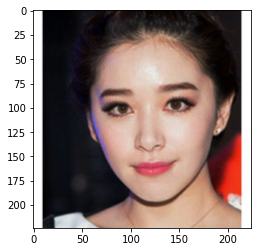

In [199]:
x=300
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im = inv_normalize(test_data[x][0])
print(test_data[x][1])
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

with torch.no_grad():
    new_pred = model(test_data[x][0].view(1,3,224,224).to(device))
    print(new_pred)

torch.Size([3, 224, 224])
tensor([[3.9418]], device='cuda:0')


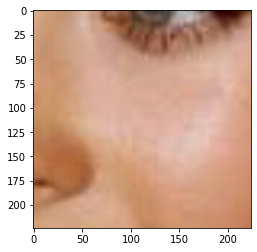

In [209]:
# im = test_transform(Image.open('SCUT-FBP5500_v2/Images/AF1976.jpg'))
im = test_transform(Image.open('bold2.jpg'))
print(im.shape)
plt.imshow(np.transpose(inv_normalize(im).numpy(), (1, 2, 0)));

with torch.no_grad():
    new_pred = model(im.view(1,3,224,224).to(device))
    print(new_pred)

In [0]:
# r = torch.jit.script(model)
# torch.jit.save(r, 'mb.pt')

In [0]:
torch.save(model.state_dict(), 'mobnet.pt')

In [0]:
model.to(torch.device('cpu'))
model.eval()
traced_script_module = torch.jit.trace(model, torch.rand(1, 3, 224, 22))
traced_script_module.save("mcpu.pt")

In [0]:
mod = torch.jit.load("mcpu.pt")
mod(torch.rand(1, 3, 224, 22))


tensor([[2.7975]], grad_fn=<AddBackward0>)

torch.Size([3, 224, 224])
tensor([[2.7252]])


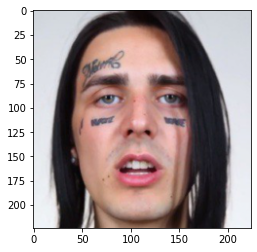

In [0]:
im = test_transform(Image.open('face.jpg'))
print(im.shape)
plt.imshow(np.transpose(inv_normalize(im).numpy(), (1, 2, 0)));

with torch.no_grad():
    new_pred = mod(im.view(1,3,224,224))
    print(new_pred)

In [0]:
y = list(filter(lambda x: x[1] == 1.083333, test_data))

# GENDER PRED

In [0]:
csv_file = '/content/SCUT-FBP5500_v2/train_test_files/split_of_60%training and 40%testing/train.txt'
df = pd.read_csv(csv_file, sep=' ', decimal='.')
df.iloc[:, 1] = df.iloc[:, 0].apply(lambda name: 0 if name[1] == 'M' else 1 )
df.groupby(df.iloc[:, 1]==0).describe()
df.to_csv('train_gender',sep=' ', decimal='.', index=False)

In [0]:
base_path = '/content/SCUT-FBP5500_v2/' 

train_data = CSVDataset(
    image_dir=os.path.join(base_path, 'Images'),
    csv_file=os.path.join('train_gender'),
    transform=train_transform)

torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
# test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [0]:
gender = models.mobilenet_v2(pretrained=True)
  # (classifier): Sequential(
  #   (0): Dropout(p=0.2, inplace=False)
  #   (1): Linear(in_features=1280, out_features=1000, bias=True)
  # )
gender.classifier = nn.Sequential(nn.Dropout(p=0.2, inplace=False),
  nn.Linear(in_features=1280, out_features=1000, bias=True),
  nn.Linear(1000, 2),
  nn.LogSoftmax(dim=1))
# nn.Sequential(nn.Linear(9216, 1024),
#                                  nn.ReLU(),
#                                  nn.Dropout(0.4),
#                                  nn.Linear(1024, 2),
#                                  nn.LogSoftmax(dim=1))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
gender.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gender.classifier.parameters(), lr=0.001)


In [0]:
len(train_data)
enumerate(train_loader)
for b, (lol, mm) in enumerate(train_loader):
  break

In [0]:
import time
start_time = time.time()

epochs = 2

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for i, (X_train, y_train) in enumerate(train_loader):
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        # Apply the model
        y_pred = gender(X_train)
        loss = criterion(y_pred, y_train.long())
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        # break
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_losses.append(loss)
    train_correct.append(trn_corr)


    print(f'epoch: {i:2}  loss: {loss.item():10.8f} accuracy: {trn_corr.item()*100/(len(train_data)):7.3f}%')

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed
gender.eval();

epoch: 103  loss: 0.00909621 accuracy:  93.695%
epoch: 103  loss: 0.01408360 accuracy:  93.453%

Duration: 34 seconds


In [0]:
y_train

tensor([1., 0., 0.], device='cuda:0', dtype=torch.float64)

torch.Size([3, 224, 224])
tensor([1], device='cuda:0')


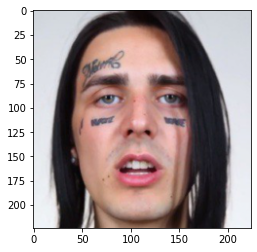

In [0]:
im = test_transform(Image.open('face.jpg'))
print(im.shape)
plt.imshow(np.transpose(inv_normalize(im).numpy(), (1, 2, 0)));

with torch.no_grad():
    new_pred = gender(im.view(1,3,224,224).to(device))
    print(torch.max(new_pred.data, 1)[1])